# Libraries

In [120]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Dataset

In [53]:
df_data = pd.read_csv('titanic.csv')
df_data

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


# Data Analysis (EDA)

In [20]:
numerical = ['age', 'parch', 'fare','alone']
categorical = ['sex', 'class', 'deck', 'embark_town']

In [54]:
df_data['is_alive'] = np.where(df_data['alive'] == 'yes', 1, 0) 

## Check Correlation between alive and numerical data

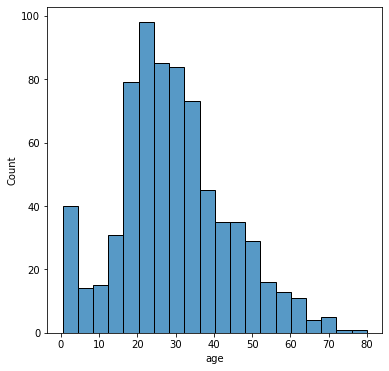

In [55]:
plt.figure(figsize=(6,6))
sns.histplot(data=df_data['age'])
plt.show()

In [56]:
df_data.corr(method='spearman')

,age,parch,fare,alone,is_alive
age,1.000000,-0.254212,0.135051,0.167293,-0.052565
parch,-0.254212,1.000000,0.410074,-0.683719,0.138266
fare,0.135051,0.410074,1.000000,-0.531472,0.323736
alone,0.167293,-0.683719,-0.531472,1.000000,-0.203367
is_alive,-0.052565,0.138266,0.323736,-0.203367,1.000000


nilai korelasi antara alive dengan age, parch dan alone berada dibawah 0.3 yang berarti nilai korelasinya rendah, maka fitur tersebut tidak akan digunakan dalam model 

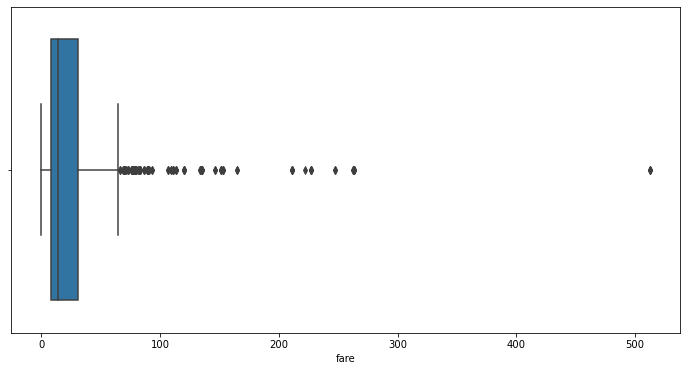

In [77]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['fare'])
plt.show()


Feature `fare` memiliki banyak outlier

## Check Correlation between alive and categorical data

In [57]:
for i in categorical:
    df_count = pd.crosstab(df_data[i], df_data['alive'])
    stats, pval, dof, expected = chi2_contingency(df_count)
    if pval <= 0.05:
        print(f'Ada keterkaitan antara {i} dan alive')
    else:
        print(f'Tidak Ada keterkaitan antara {i} dan alive')


Ada keterkaitan antara sex dan alive
Ada keterkaitan antara class dan alive
Tidak Ada keterkaitan antara deck dan alive
Ada keterkaitan antara embark_town dan alive


## Check Missing Values

Berdasarkan 2 point diatas, maka fitur yang akan digunakan adalah : fare, sex, class, dan embark_town

In [61]:
df = df_data[['is_alive', 'sex', 'class', 'embark_town', 'fare']]

In [78]:
df.head()

,is_alive,sex,class,embark_town,fare
0,0,male,Third,Southampton,7.2500
1,1,female,First,Cherbourg,71.2833
2,1,female,Third,Southampton,7.9250
3,1,female,First,Southampton,53.1000
4,0,male,Third,Southampton,8.0500


In [63]:
df.isna().sum()

is_alive       0
sex            0
class          0
embark_town    2
fare           0
dtype: int64

In [70]:
df['embark_town'].fillna(value=df['embark_town'].mode().item(), inplace=True)

In [71]:
df.isna().sum()

is_alive       0
sex            0
class          0
embark_town    0
fare           0
dtype: int64

# Preprocessing
1. Category Encoders Library: class (Ordinal Data)
2. One Hot Encoding : sex, embark_town (Nominal Data)
3. Robust Scaler : fare (Numeric Data yang memiliki banyak outlier)

## Category Encoders Library for Ordinal Data

In [79]:
df['class'].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

In [84]:
ordinal_mapping = [
    {
        'col': 'class',
        'mapping': {None:0, 'First':1, 'Second': 2, 'Third':3}
    }
]

In [85]:
ordinal_encoder = ce.OrdinalEncoder(mapping=ordinal_mapping)
df['class'] = ordinal_encoder.fit_transform(df['class'])
df.head()

<ipython-input-85-d184c6a1c02b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = ordinal_encoder.fit_transform(df['class'])


,is_alive,sex,class,embark_town,fare
0,0,male,3,Southampton,7.2500
1,1,female,1,Cherbourg,71.2833
2,1,female,3,Southampton,7.9250
3,1,female,1,Southampton,53.1000
4,0,male,3,Southampton,8.0500


In [89]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex','embark_town']), # name, transformer, kolom
    ('robust',RobustScaler(), ['fare'])
], remainder='passthrough')

In [90]:
transformer.fit_transform(df)

array([[ 1.        ,  0.        ,  1.        , -0.3120106 ,  0.        ,
         3.        ],
       [ 0.        ,  0.        ,  0.        ,  2.46124229,  1.        ,
         1.        ],
       [ 0.        ,  0.        ,  1.        , -0.28277666,  1.        ,
         3.        ],
       ...,
       [ 0.        ,  0.        ,  1.        ,  0.38960398,  0.        ,
         3.        ],
       [ 1.        ,  0.        ,  0.        ,  0.67328148,  1.        ,
         1.        ],
       [ 1.        ,  1.        ,  0.        , -0.29035583,  0.        ,
         3.        ]])

# Data Splitting

In [91]:
x = df.drop(columns='is_alive')
y = df['is_alive']

# Data Transform

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=10)

In [95]:
transformer.transformers_

[('one hot', OneHotEncoder(drop='first'), ['sex', 'embark_town']),
 ('robust', RobustScaler(), ['fare']),
 ('remainder', 'passthrough', [0, 2])]

In [96]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_male', 'x1_Queenstown', 'x1_Southampton'], dtype=object)

In [99]:
features = list(transformer.transformers_[0][1].get_feature_names()) + ['fare scaled', 'class']
features

['x0_male', 'x1_Queenstown', 'x1_Southampton', 'fare scaled', 'class']

In [100]:
x_train_preprocessed = transformer.fit_transform(x_train)
x_test_preprocessed = transformer.transform(x_test)

In [101]:
x_train_preprocessed = pd.DataFrame(x_train_preprocessed)
x_test_preprocessed = pd.DataFrame(x_test_preprocessed)

In [108]:
x_train_preprocessed.columns = features
x_train_preprocessed

,x0_male,x1_Queenstown,x1_Southampton,fare scaled,class
0,0.0,0.0,0.0,-0.001777,3.0
1,0.0,0.0,1.0,0.618007,2.0
2,0.0,1.0,0.0,-0.330314,3.0
3,1.0,0.0,1.0,-0.274907,3.0
4,1.0,0.0,1.0,1.789912,3.0
...,...,...,...,...,...
663,0.0,0.0,0.0,2.335642,1.0
664,1.0,0.0,1.0,-0.309004,3.0
665,1.0,0.0,1.0,8.834489,1.0
666,1.0,0.0,0.0,-0.138873,3.0


In [109]:
x_test_preprocessed.columns = features
x_test_preprocessed

,x0_male,x1_Queenstown,x1_Southampton,fare scaled,class
0,1.0,0.0,1.0,-0.314331,3.0
1,1.0,0.0,1.0,-0.317528,3.0
2,1.0,0.0,1.0,-0.281479,3.0
3,0.0,0.0,0.0,5.626885,1.0
4,0.0,0.0,1.0,2.939798,1.0
...,...,...,...,...,...
218,1.0,0.0,1.0,-0.274907,3.0
219,1.0,0.0,0.0,-0.310069,3.0
220,0.0,0.0,1.0,-0.170485,2.0
221,1.0,0.0,1.0,-0.063932,2.0


# Model Fitting & Evaluation

## Logistic Regression

In [114]:
model=LogisticRegression()
model.fit(x_train_preprocessed, y_train)
modelAccScore = accuracy_score(y_test,model.predict(x_test_preprocessed))

print('model accuracy score in test dataset: ', modelAccScore)

model accuracy score in test dataset:  0.8251121076233184


## KNN Classifier

In [118]:
# Choose Factor K
k = range(1, 100, 2) # nilai k lebih baik kalau ganjil
testing_score = []
training_score = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_preprocessed, y_train)
    
    y_predict_test = knn.predict(x_test_preprocessed)
    acc_score = accuracy_score(y_test, y_predict_test)
    testing_score.append(acc_score)
    
    if score < acc_score:
        score = acc_score
        best_k = i

print('best k : ', best_k)
print('model accuracy score in test dataset : ', score)

best k :  53
model accuracy score in test dataset :  0.8295964125560538


## Decision Tree

In [123]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3) # criterion{“gini”, “entropy”}, default=”gini”
tree.fit(x_train_preprocessed, y_train)
y_predict = tree.predict(x_test_preprocessed)

modelAccScore = accuracy_score(y_test, y_predict)
print('Nilai akurasi model ini: ', modelAccScore)

Nilai akurasi model ini:  0.8251121076233184
